## Loading of Steinmetz data

includes some visualizations

In [2]:
#@title Data retrieval
import os, requests

fname = []
for j in range(3):
  fname.append('steinmetz_part%d.npz'%j)
url = ["https://osf.io/agvxh/download"]
url.append("https://osf.io/uv3mw/download")
url.append("https://osf.io/ehmw2/download")

for j in range(len(url)):
  if not os.path.isfile(fname[j]):
    try:
      r = requests.get(url[j])
    except requests.ConnectionError:
      print("!!! Failed to download data !!!")
    else:
      if r.status_code != requests.codes.ok:
        print("!!! Failed to download data !!!")
      else:
        with open(fname[j], "wb") as fid:
          fid.write(r.content)


In [3]:
#@title Data loading
import numpy as np

alldat = np.array([])
for j in range(len(fname)):
  alldat = np.hstack((alldat, np.load('steinmetz_part%d.npz'%j, allow_pickle=True)['dat']))

# select just one of the recordings here. 11 is nice because it has some neurons in vis ctx. 
dat = alldat[11]
print(dat.keys())

dict_keys(['spks', 'wheel', 'pupil', 'response', 'response_time', 'bin_size', 'stim_onset', 'contrast_right', 'contrast_left', 'brain_area', 'feedback_time', 'feedback_type', 'gocue', 'mouse_name', 'date_exp', 'trough_to_peak', 'active_trials', 'contrast_left_passive', 'contrast_right_passive', 'spks_passive', 'pupil_passive', 'wheel_passive', 'prev_reward', 'ccf', 'ccf_axes', 'cellid_orig', 'reaction_time', 'face', 'face_passive', 'licks', 'licks_passive'])


`alldat` contains 39 sessions from 10 mice, data from Steinmetz et al, 2019. Time bins for all measurements are 10ms, starting 500ms before stimulus onset. The mouse had to determine which side has the highest contrast. For each `dat = alldat[k]`, you have the following fields:

* `dat['mouse_name']`: mouse name
* `dat['date_exp']`: when a session was performed
* `dat['spks']`: neurons by trials by time bins.    
* `dat['brain_area']`: brain area for each neuron recorded. 
* `dat['contrast_right']`: contrast level for the right stimulus, which is always contralateral to the recorded brain areas.
* `dat['contrast_left']`: contrast level for left stimulus. 
* `dat['gocue']`: when the go cue sound was played. 
* `dat['response_times']`: when the response was registered, which has to be after the go cue. The mouse can turn the wheel before the go cue (and nearly always does!), but the stimulus on the screen won't move before the go cue.  
* `dat['response']`: which side the response was (`-1`, `0`, `1`). When the right-side stimulus had higher contrast, the correct choice was `-1`. `0` is a no go response. 
* `dat['feedback_time']`: when feedback was provided. 
* `dat['feedback_type']`: if the feedback was positive (`+1`, reward) or negative (`-1`, white noise burst).  
* `dat['wheel']`: exact position of the wheel that the mice uses to make a response, binned at `10ms`. 
* `dat['pupil']`: pupil area  (noisy, because pupil is very small) + pupil horizontal and vertical position. 
* `dat['lfp']`: recording of the local field potential in each brain area from this experiment, binned at `10ms`.
* `dat['brain_area_lfp']`: brain area names for the LFP channels. 
* `dat['trough_to_peak']`: measures the width of the action potential waveform for each neuron. Widths `<=10` samples are "putative fast spiking neurons". 
* `dat['waveform_w']`: temporal components of spike waveforms. `w@u` reconstructs the time by channels action potential shape. 
* `dat['waveform_u]`: spatial components of spike waveforms.
* `dat['%X%_passive']`: same as above for `X` = {`spks`, `lfp`, `pupil`, `wheel`, `contrast_left`, `contrast_right`} but for  passive trials at the end of the recording when the mouse was no longer engaged and stopped making responses. 




In [4]:
#@title import matplotlib and set defaults
from matplotlib import rcParams 
from matplotlib import pyplot as plt
rcParams['figure.figsize'] = [20, 4]
rcParams['font.size'] =15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

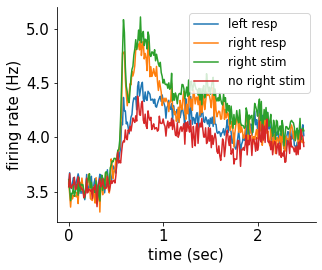

In [5]:
#@title basic plots of population average
from matplotlib import pyplot as plt
dt = dat['bin_size'] # binning at 10 ms
NT = dat['spks'].shape[-1]

ax = plt.subplot(1,5,1)
response = dat['response'] # right - nogo - left (-1, 0, 1)
vis_right = dat['contrast_right'] # 0 - low - high
vis_left = dat['contrast_left'] # 0 - low - high
plt.plot(dt * np.arange(NT), 1/dt * dat['spks'][:,response>=0].mean(axis=(0,1))) # left responses
plt.plot(dt * np.arange(NT), 1/dt * dat['spks'][:,response<0].mean(axis=(0,1))) # right responses
plt.plot(dt * np.arange(NT), 1/dt * dat['spks'][:,vis_right>0].mean(axis=(0,1))) # stimulus on the right
plt.plot(dt * np.arange(NT), 1/dt * dat['spks'][:,vis_right==0].mean(axis=(0,1))) # no stimulus on the right

plt.legend(['left resp', 'right resp', 'right stim', 'no right stim'], fontsize=12)
ax.set(xlabel  = 'time (sec)', ylabel = 'firing rate (Hz)');

In [6]:
# groupings of brain regions
regions = ["vis ctx", "thal", "hipp", "other ctx", "midbrain", "basal ganglia", "cortical subplate", "other"]
brain_groups = [["VISa", "VISam", "VISl", "VISp", "VISpm", "VISrl"], # visual cortex
                ["CL", "LD", "LGd", "LH", "LP", "MD", "MG", "PO", "POL", "PT", "RT", "SPF", "TH", "VAL", "VPL", "VPM"], # thalamus
                ["CA", "CA1", "CA2", "CA3", "DG", "SUB", "POST"], # hippocampal
                ["ACA", "AUD", "COA", "DP", "ILA", "MOp", "MOs", "OLF", "ORB", "ORBm", "PIR", "PL", "SSp", "SSs", "RSP"," TT"], # non-visual cortex
                ["APN", "IC", "MB", "MRN", "NB", "PAG", "RN", "SCs", "SCm", "SCig", "SCsg", "ZI"], # midbrain
                ["ACB", "CP", "GPe", "LS", "LSc", "LSr", "MS", "OT", "SNr", "SI"], # basal ganglia 
                ["BLA", "BMA", "EP", "EPd", "MEA"] # cortical subplate
                ]

nareas = 4 # only the top 4 regions are in this particular mouse
NN = len(dat['brain_area']) # number of neurons
barea = nareas * np.ones(NN, ) # last one is "other"
for j in range(nareas):
  barea[np.isin(dat['brain_area'], brain_groups[j])] = j # assign a number to each region

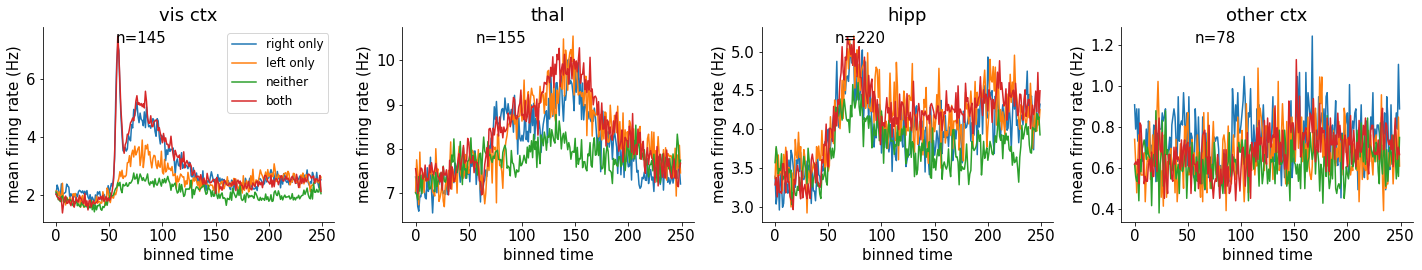

In [7]:
#@title plots by brain region and visual conditions
for j in range(nareas):
  ax = plt.subplot(1,nareas,j+1)
  
  plt.plot(1/dt *  dat['spks'][barea==j][:,np.logical_and(vis_left==0, vis_right>0)].mean(axis=(0,1)))
  plt.plot(1/dt *  dat['spks'][barea==j][:,np.logical_and(vis_left>0 , vis_right==0)].mean(axis=(0,1)))
  plt.plot(1/dt *  dat['spks'][barea==j][:,np.logical_and(vis_left==0 , vis_right==0)].mean(axis=(0,1)))
  plt.plot(1/dt *  dat['spks'][barea==j][:,np.logical_and(vis_left>0, vis_right>0)].mean(axis=(0,1)))  
  plt.text(.25, .92, 'n=%d'%np.sum(barea==j), transform=ax.transAxes)
 
  if j==0:
    plt.legend(['right only', 'left only', 'neither', 'both'], fontsize=12)
  ax.set(xlabel = 'binned time', ylabel = 'mean firing rate (Hz)', title = regions[j])


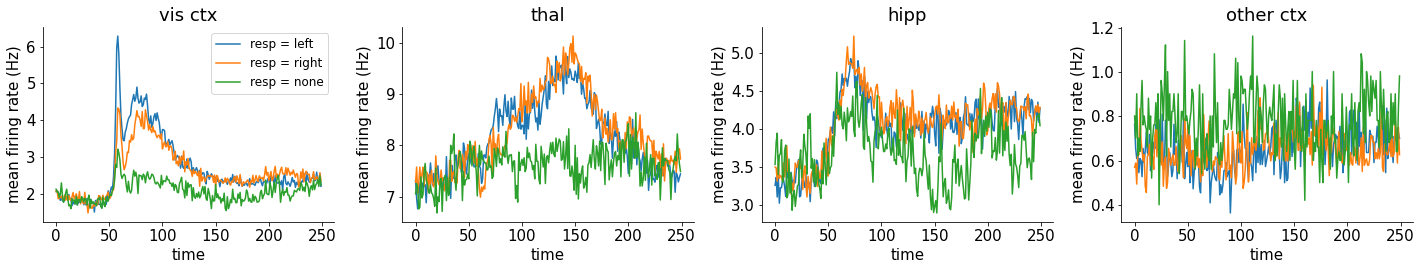

In [8]:
#@title plots by brain region and response type
for j in range(nareas):
  ax = plt.subplot(1,nareas,j+1)
  plt.title(regions[j])
  if np.sum(barea==j)==0:
    continue
  plt.plot(1/dt * dat['spks'][barea==j][:,response<0].mean(axis=(0,1)))  
  plt.plot(1/dt * dat['spks'][barea==j][:,response>0].mean(axis=(0,1)))
  plt.plot(1/dt * dat['spks'][barea==j][:,response==0].mean(axis=(0,1)))
 
  if j==0:
    plt.legend(['resp = left', 'resp = right', 'resp = none'], fontsize=12)
  ax.set(xlabel = 'time', ylabel = 'mean firing rate (Hz)')


In [9]:
#@title top PC directions from stimulus + response period, with projections of the entire duration
from sklearn.decomposition import PCA 

droll = np.reshape(dat['spks'][:,:,51:130], (NN,-1)) # first 80 bins = 1.6 sec
droll = droll - np.mean(droll, axis=1)[:, np.newaxis]
model = PCA(n_components = 5).fit(droll.T)
W = model.components_
pc_10ms = W @ np.reshape(dat['spks'], (NN,-1))
pc_10ms = np.reshape(pc_10ms, (5, -1, NT))

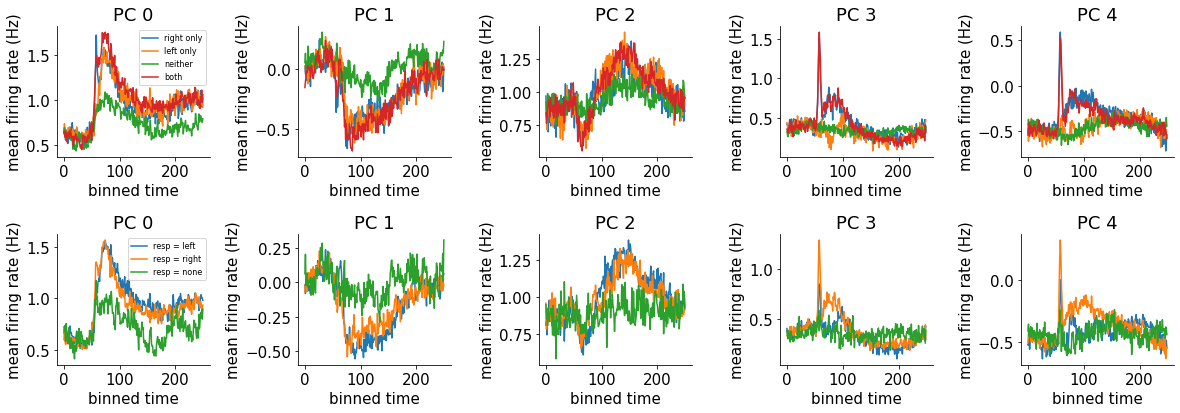

In [10]:
#@title The top PCs capture most variance across the brain. What do they care about? 
plt.figure(figsize= (20, 6))
for j in range(len(pc_10ms)):
  ax = plt.subplot(2,len(pc_10ms)+1,j+1)
  pc1 = pc_10ms[j]

  plt.plot(pc1[np.logical_and(vis_left==0, vis_right>0), :].mean(axis=0))  
  plt.plot(pc1[np.logical_and(vis_left>0, vis_right==0), :].mean(axis=0))
  plt.plot(pc1[np.logical_and(vis_left==0, vis_right==0), :].mean(axis=0))
  plt.plot(pc1[np.logical_and(vis_left>0, vis_right>0), :].mean(axis=0))
   
  if j==0:
    plt.legend(['right only', 'left only', 'neither', 'both'], fontsize=8)
  ax.set(xlabel = 'binned time', ylabel = 'mean firing rate (Hz)')
  plt.title('PC %d'%j)

  ax = plt.subplot(2,len(pc_10ms)+1,len(pc_10ms)+1 + j+1)
  
  plt.plot(pc1[response>0, :].mean(axis=0))  
  plt.plot(pc1[response<0, :].mean(axis=0))
  plt.plot(pc1[response==0, :].mean(axis=0))

  if j==0:
    plt.legend(['resp = left', 'resp = right', 'resp = none'], fontsize=8)
  ax.set(xlabel = 'binned time', ylabel = 'mean firing rate (Hz)')
  plt.title('PC %d'%j)

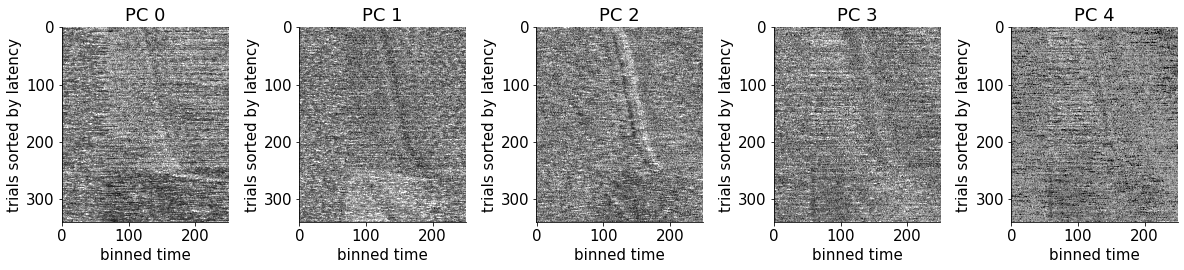

In [11]:
#@title now sort all trials by response latency and see if the PCs care about that.
from scipy.stats import zscore

isort = np.argsort(dat['response_time'].flatten())

for j in range(len(pc_10ms)):
  ax = plt.subplot(1,len(pc_10ms)+1,j+1)
  pc1 = zscore(pc_10ms[j])
  plt.imshow(pc1[isort, :], aspect='auto', vmax=2, vmin = -2, cmap = 'gray')
  ax.set(xlabel = 'binned time', ylabel = 'trials sorted by latency')
  plt.title('PC %d'%j)

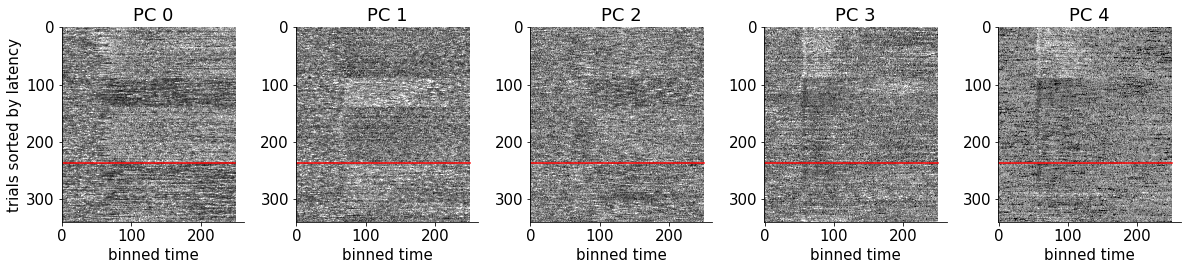

In [12]:
#@title correct vs incorrect trials
# the following are the correct responses:
# if vis_left > vis_right : response >0
# if vis_left < vis_right : response <0
# if vis_left = vis_right : response =0
# trials below red line are incorrect
is_correct = np.sign(response)==np.sign(vis_left-vis_right)

# sort by correct, and then by response
isort = np.argsort(-is_correct.astype('float32') + response/10) 

nwrong = np.sum(is_correct)
for j in range(len(pc_10ms)):
  ax = plt.subplot(1,len(pc_10ms)+1,j+1)
  pc1 = zscore(pc_10ms[j])
  plt.imshow(pc1[isort, :], aspect='auto', vmax=2, vmin = -2, cmap = 'gray')
  ax.set(xlabel = 'binned time')
  if j==0:
    ax.set(ylabel = 'trials sorted by latency')  
  plt.title('PC %d'%j)

  plt.plot([0, NT], [nwrong, nwrong], 'r')


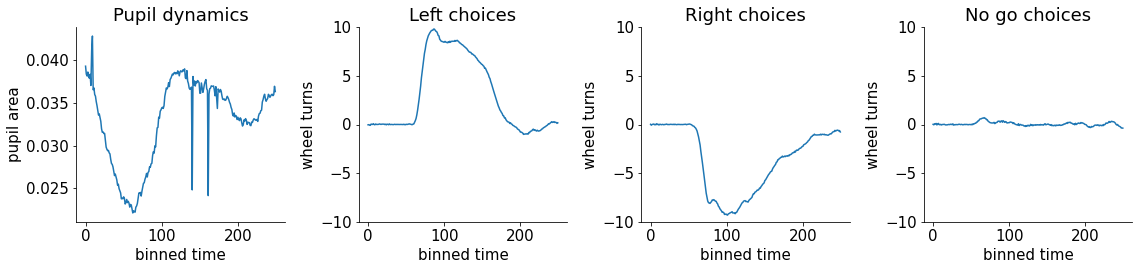

In [13]:
# plot the behavioral data (pupil area is noisy because it's very small)

ax = plt.subplot(1,5,1)
plt.plot(dat['pupil'][0, :].mean(0));
ax.set(ylabel='pupil area', xlabel = 'binned time', title='Pupil dynamics')

yl = [-10, 10]
ax = plt.subplot(1,5,2)
plt.plot(dat['wheel'][0, response>0].mean(0));
ax.set(ylim=yl)
ax.set(ylim=yl, ylabel='wheel turns', xlabel = 'binned time', title='Left choices');

ax = plt.subplot(1,5,3)
plt.plot(dat['wheel'][0, response<0].mean(0));
ax.set(ylim=yl)
ax.set(ylim=yl, ylabel='wheel turns', xlabel = 'binned time', title='Right choices');

ax = plt.subplot(1,5,4)
plt.plot(dat['wheel'][0, response==0].mean(0));
ax.set(ylim=yl, ylabel='wheel turns', xlabel = 'binned time', title='No go choices');


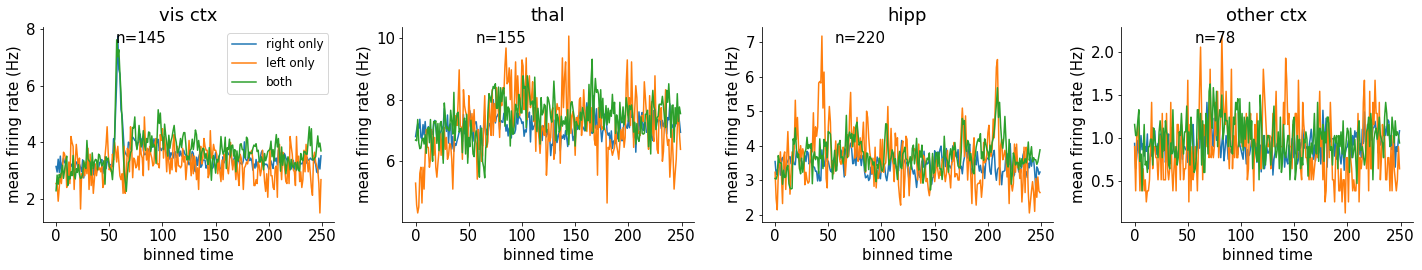

In [14]:
# plots by brain region and visual conditions for PASSIVE trials
vis_left_p = dat['contrast_left_passive']
vis_right_p = dat['contrast_right_passive']
for j in range(nareas):
  ax = plt.subplot(1,nareas,j+1)
  plt.title(regions[j])
  
  plt.plot(1/dt *  dat['spks_passive'][barea==j][:,np.logical_and(vis_left_p==0, vis_right_p>0)].mean(axis=(0,1)))
  plt.plot(1/dt *  dat['spks_passive'][barea==j][:,np.logical_and(vis_left_p>0 , vis_right_p==0)].mean(axis=(0,1)))
  #plt.plot(1/dt *  dat['spks_passive'][barea==j][:,np.logical_and(vis_left_p==0 , vis_right_p==0)].mean(axis=(0,1)))
  plt.plot(1/dt *  dat['spks_passive'][barea==j][:,np.logical_and(vis_left_p>0, vis_right_p>0)].mean(axis=(0,1)))  
  plt.text(.25, .92, 'n=%d'%np.sum(barea==j), transform=ax.transAxes)
 
  if j==0:
    plt.legend(['right only', 'left only', 'both'], fontsize=12)
  ax.set(xlabel = 'binned time', ylabel = 'mean firing rate (Hz)')

In [15]:
slow_resp = dat['response_time'] > np.mean(dat['response_time'])
slow_resp.squeeze()
slow_resp = slow_resp.reshape(slow_resp.shape[0]); slow_resp.shape

(340,)

In [16]:
dat['spks'][barea==3].shape[2]

250

In [17]:
pc_10ms.shape

(5, 340, 250)

# fast vs slow reaction time

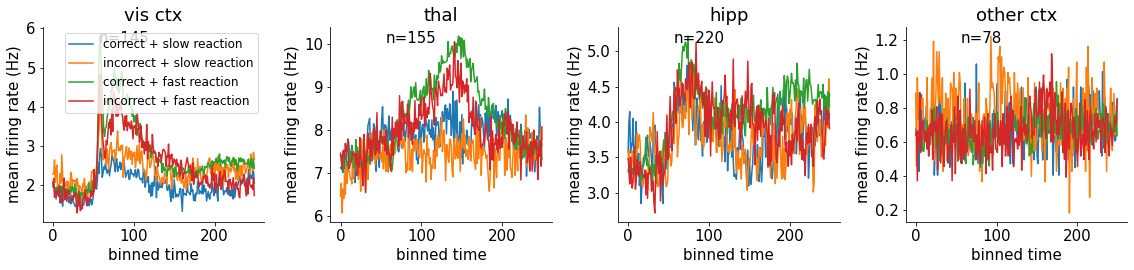

In [ ]:
#@title plots by brain region and visual conditions
for j in range(4): #len(brain_groups)+1):
  ax = plt.subplot(1,5, j+1) # len(brain_groups)+1,j+1)
  plt.title(regions[j])
  b_spikes = dat['spks'][barea==j];
  plt.plot(1/dt *  b_spikes[:,np.logical_and(is_correct, slow_resp)].mean(axis=(0,1)))
  plt.plot(1/dt *  b_spikes[:,np.logical_and(~is_correct, slow_resp)].mean(axis=(0,1)))
  plt.plot(1/dt *  b_spikes[:,np.logical_and(is_correct, ~slow_resp)].mean(axis=(0,1)))
  plt.plot(1/dt *  b_spikes[:,np.logical_and(~is_correct, ~slow_resp)].mean(axis=(0,1)))  
  plt.text(.25, .92, 'n=%d'%np.sum(barea==j), transform=ax.transAxes)
 
  if j==0:
    plt.legend(['correct + slow reaction', 'incorrect + slow reaction', 'correct + fast reaction', 'incorrect + fast reaction'], fontsize=12)
  ax.set(xlabel = 'binned time', ylabel = 'mean firing rate (Hz)')
  #plt.plot(dat['spks_20ms'][barea==j][:,vis_right>0].mean(axis=(0,1)))
  #plt.plot(dat['spks_20ms'][barea==j][:,vis_right==0].mean(axis=(0,1)))

In [ ]:
is_large_margin = np.abs(vis_left - vis_right) > 0.49
is_large_margin.shape

(340,)

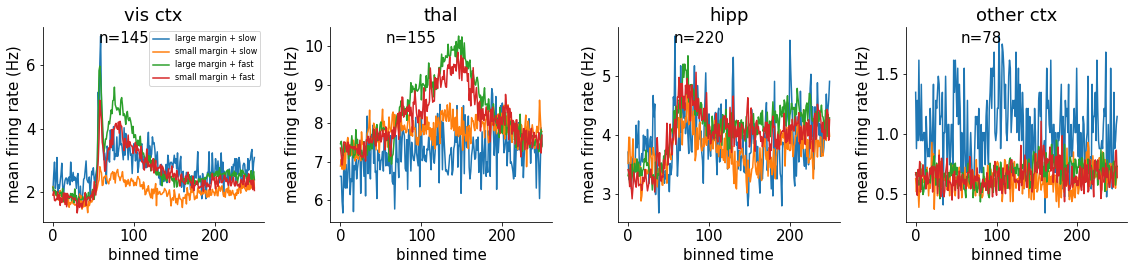

In [ ]:
#@title plots by brain region and visual conditions
for j in range(4): #len(brain_groups)+1):
  ax = plt.subplot(1,5, j+1) # len(brain_groups)+1,j+1)
  plt.title(regions[j])
  b_spikes = dat['spks'][barea==j];
  plt.plot(1/dt *  b_spikes[:,np.logical_and(is_large_margin, slow_resp)].mean(axis=(0,1)))
  plt.plot(1/dt *  b_spikes[:,np.logical_and(~is_large_margin, slow_resp)].mean(axis=(0,1)))
  plt.plot(1/dt *  b_spikes[:,np.logical_and(is_large_margin, ~slow_resp)].mean(axis=(0,1)))
  plt.plot(1/dt *  b_spikes[:,np.logical_and(~is_large_margin, ~slow_resp)].mean(axis=(0,1)))  
  plt.text(.25, .92, 'n=%d'%np.sum(barea==j), transform=ax.transAxes)
 
  if j==0:
    plt.legend(['large margin + slow', 'small margin + slow', 'large margin + fast', 'small margin + fast'], fontsize=8)
  ax.set(xlabel = 'binned time', ylabel = 'mean firing rate (Hz)')
  #plt.plot(dat['spks_20ms'][barea==j][:,vis_right>0].mean(axis=(0,1)))
  #plt.plot(dat['spks_20ms'][barea==j][:,vis_right==0].mean(axis=(0,1)))

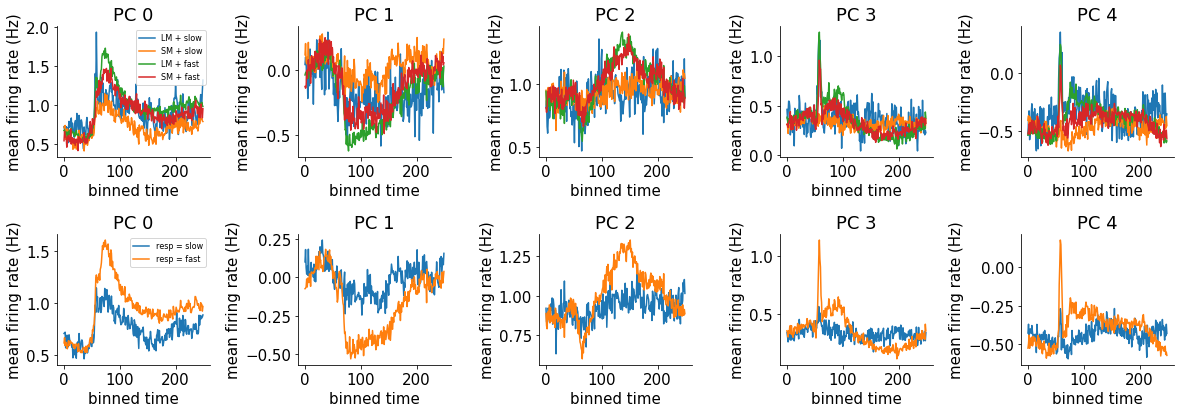

In [ ]:
#@title The top PCs capture most variance across the brain. What do they care about? 
plt.figure(figsize= (20, 6))
for j in range(len(pc_10ms)):
  ax = plt.subplot(2,len(pc_10ms)+1,j+1)
  pc1 = pc_10ms[j]

  plt.plot(pc1[np.logical_and(is_large_margin, slow_resp), :].mean(axis=0))  
  plt.plot(pc1[np.logical_and(~is_large_margin, slow_resp), :].mean(axis=0))
  plt.plot(pc1[np.logical_and(is_large_margin, ~slow_resp), :].mean(axis=0))
  plt.plot(pc1[np.logical_and(~is_large_margin, ~slow_resp), :].mean(axis=0))
   
  if j==0:
    plt.legend(['LM + slow', 'SM + slow', 'LM + fast', 'SM + fast'], fontsize=8)
  ax.set(xlabel = 'binned time', ylabel = 'mean firing rate (Hz)')
  plt.title('PC %d'%j)

  ax = plt.subplot(2,len(pc_10ms)+1,len(pc_10ms)+1 + j+1)
  
  plt.plot(pc1[slow_resp, :].mean(axis=0))  
  plt.plot(pc1[~slow_resp, :].mean(axis=0))

  if j==0:
    plt.legend(['resp = slow', 'resp = fast'], fontsize=8)
  ax.set(xlabel = 'binned time', ylabel = 'mean firing rate (Hz)')
  plt.title('PC %d'%j)

Clustering

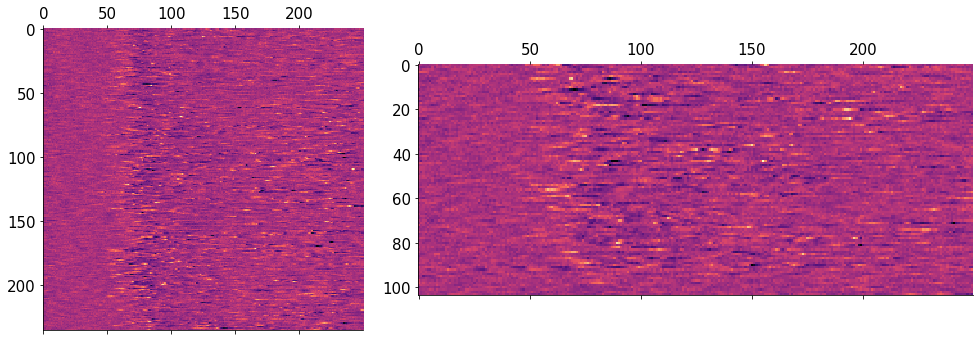

In [ ]:
from sklearn.cluster import KMeans
fig,ax=plt.subplots(1,2, figsize=(15,5))
lfp = dat["spikes"][:] # ACA
ax[0].matshow(lfp[is_correct, :], cmap='magma');
ax[1].matshow(lfp[~is_correct, :], cmap='magma');
plt.tight_layout()

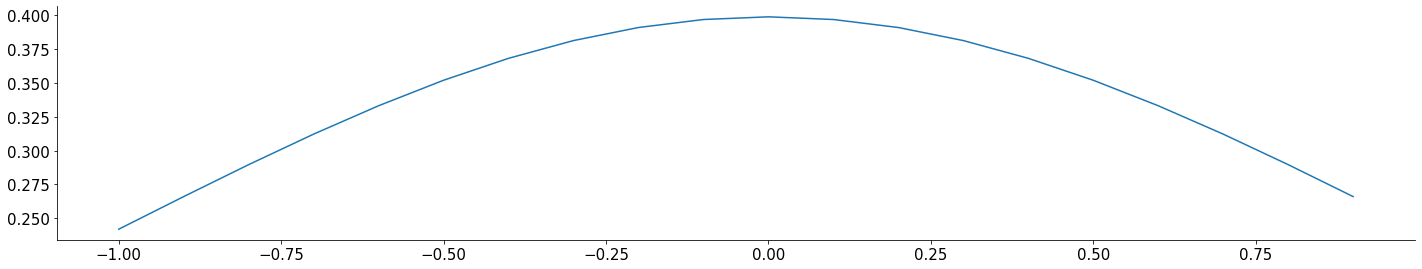

In [ ]:
x = np.arange(-1, 1, 0.1)
gaussian = 1/np.sqrt(2*np.pi)* np.exp(-x ** 2 /2.)
plt.plot(x,gaussian)

In [ ]:
#@title Helper Functions #427
import numpy as np
from sklearn.decomposition import PCA
from copy import deepcopy as cdc
np.set_printoptions(precision=3,floatmode="fixed") # set num of digits after decimal

def Clamp427(val,min_val,max_val):
   return max(min(val,max_val),min_val)

# Weber Fechner Law related function
def WF_filter427(vis_left,vis_right,base_val,diff,dir='UP'):
  """WF_filter based on the baseline value base_val & difference diff
  In this function left and right are indistinguishable
  Args:
    vis_left (1D np.arr of floats): contrast level for the left stimulus at each trial
    vis_right (1D np.arr of floats): contrast level for the right stimulus at each trial
    base_val (float): e.g., 0,0.25,0.5,1
    diff (float): e.g., 0,0.25,0.5,0.75,1
  KeyArg:
    dir (str):
      'UP': upward comparison: base_val is always the smaller value
      'DOWN': downward comparison: base_val is always the larger value
      'BI': bi-directional, base_val can be the smaller one or the larger one
  Return:
    boo (1D boolean np.arr): True if difference satistfies diff, and one of them is base_val
  """

  if dir=='BI': # bi-directional
    Boo1 = np.isclose(np.abs(vis_left-vis_right), diff, rtol=0) # difference check
    Boo2 = np.logical_or(np.isclose(vis_left, base_val, rtol=0),\
                            np.isclose(vis_right, base_val, rtol=0)) # base check
    return np.logical_and(Boo1,Boo2)
  else: # uni-directional
    LBaseBoo = np.isclose(vis_left, base_val, rtol=0) # left is base
    RBaseBoo = np.isclose(vis_right, base_val, rtol=0) # right is base
    if dir=='UP':
      LdiffBoo = np.isclose(vis_left + diff, vis_right, rtol=0)
      RdiffBoo = np.isclose(vis_right + diff, vis_left, rtol=0)
    elif dir=='DOWN':
      LdiffBoo = np.isclose(vis_left - diff, vis_right, rtol=0)
      RdiffBoo = np.isclose(vis_right - diff, vis_left, rtol=0)
    else:
      raise ValueError('<dir> keyword argument is unclear.')
    Boo1 = np.logical_and(LBaseBoo,LdiffBoo) # left case
    Boo2 = np.logical_and(RBaseBoo,RdiffBoo) # right case
    return np.logical_or(Boo1,Boo2) # left or right, hence indistinguishable

# variance explained hunting

def smoothDat(dat, kernel = None): # return a deep copy of dat by smoothening it using kernel
  if kernel == None: # define a gaussian kernel (mu=0, sigma=1)
    kernel = lambda x : 1/np.sqrt(2*np.pi)* np.exp(-x ** 2 /2.) # Guassian kernel
  dat_ = cdc(dat) # make a deep copy
  x = np.arange(-1, 1, 0.1) # size 20 filter
  for i in range(dat_['spks'].shape[0]):
    for j in range(dat_['spks'].shape[1]):
      dat_['spks'][i, j, :] = np.convolve(dat_['spks'][i, j, :], kernel(x), 'same')
  return dat_

def VarHunter427(dat, trial_ave = None, time_seg = None, nPC = 4):
  """ Given a session of data: dat
      print out variance explained using PCA on spike data by brain sub-regions
  Args:
    dat (np.arr):
      dat = alldat[s] s:= session number
    trial_ave (arr like object):
      trial number to average over; if None, then stack all time steps along all trials
    time_seg (slice object): # first 80 bins = 1.6 sec
      specify the slice of time (3rd dim in dat['spks']) over which PCA is done
    nPC (int):
      number of principal components
  Return:

  """
  nTimebins = dat['spks'].shape[-1] # number of bins
  if time_seg == None:
    time_seg == slice(51,130) # default
  list_var = list() # list of lists
  list_tot = list() # list of floats
  list_PC_NN = list() # list of len 2 tuples storing nPC and NN_
  brain_arr = list(set(dat['brain_area'])) # all unique brain_areas
  for str_ in brain_arr: # iterate over all unique brain_areas
      filter_ = np.isin(dat['brain_area'], [str_])
      NN_ = filter_.sum()
      # stack all of the time bins along trials (collapse dim 1 and 2)
      droll = np.reshape(dat['spks'][filter_][:,:,time_seg], (NN_,-1))
      droll = droll - np.mean(droll, axis=1)[:, np.newaxis]
      nPC = Clamp427(nPC, 0, min(droll.shape[0],droll.shape[1])) # 0: n_features, 1: n_samples
      model = PCA(n_components = nPC).fit(droll.T)
      W = model.components_
      pc_10ms = W @ np.reshape(dat['spks'][filter_], (NN_,-1))
      pc_10ms = np.reshape(pc_10ms, (nPC, -1, nTimebins))
      variance_perc = model.explained_variance_ratio_
      tot_var = np.sum(variance_perc)
      list_var.append(variance_perc)
      list_tot.append(tot_var)
      list_PC_NN.append((nPC, droll.shape[0]))
  list_var = np.array(list_var)
  list_tot = np.array(list_tot)
  brain_arr = np.array(brain_arr)
  list_PC_NN = np.array(list_PC_NN)

  by_totnPC = np.argsort(list_tot)[::-1] # descending order
  list_var = list_var[by_totnPC]
  list_tot = list_tot[by_totnPC]
  brain_arr = brain_arr[by_totnPC]
  list_PC_NN = list_PC_NN[by_totnPC]
  for i in range(len(list_tot)):
      print('region: ', brain_arr[i].ljust(5), 'PC:n_features ' \
            , list_PC_NN[i][0], ':', str(list_PC_NN[i][1]).ljust(4) \
            , 'total: %.3f' %list_tot[i], 'var explained: ', list_var[i])
  
def BrainRegions427(alldat, nestedSort = True):
  """ Given alldat: see returns for the purpose of this function
  Args:
    alldat (1D np.arr):
      contains len(alldat) sessions of dat
    nestedSort (bool):
      if True:
        temp & sessionList is sorted by the num of sessions region showed up
        items inside sessionList is sorted by number of neurons in the region
  Return (all np.arr):
    temp, sessionList, neuronNumList: (sorted by num of sessions)
    temp =        ['region4',              'region2', ...]
    sessionList =  [[0,    1,  2,10],      [4, 2,7], ...]
    neuronNumList = [[427, 42, 7, 2],      [10,9,8], ...]
    so basically: region i's name: temp[i];
                  it showed up in these sessions: sessionList[i]
                  each session has these numbers of neurons: neuronNumList[i]
  """
  temp = set()
  for s in range(len(alldat)):
    temp = (set(alldat[s]['brain_area']) | temp) # | is union operator
  temp = np.array(list(temp))
  # find session indices the region showed up
  sessionList = list()
  neuronNumList = list()
  for str_ in temp:
    sessionList.append(np.array([s for s in range(len(alldat)) if str_ in alldat[s]['brain_area']]))
    neuronNumList.append(np.array([sum([1 for j in alldat[i]['brain_area'] if j == str_]) \
                          for i in sessionList[-1]]))
  # convert to np.arr
  temp = np.array(temp)
  sessionList = np.array(sessionList)
  neuronNumList = np.array(neuronNumList)
  if nestedSort: # sort temp by number of sessions they appeared in
    Mask_ = np.argsort([len(i) for i in sessionList])[::-1]
    temp = temp[Mask_]
    sessionList = sessionList[Mask_]
    neuronNumList = neuronNumList[Mask_]
    for i in range(len(temp)): # sort sessionList[i] by number of neurons from region i
      Mask_ = np.argsort(neuronNumList[i])[::-1]
      sessionList[i] = sessionList[i][Mask_]
      neuronNumList[i] = neuronNumList[i][Mask_]
  return temp, sessionList, neuronNumList


In [ ]:
#@title Helper Functions #427
import numpy as np
from sklearn.decomposition import PCA
np.set_printoptions(precision=3,floatmode="fixed") # set num of digits after decimal

def Clamp427(val,min_val,max_val):
   return max(min(val,max_val),min_val)

# Weber Fechner Law related function
def WF_filter427(vis_left,vis_right,base_val,diff,dir='UP'):
  """WF_filter based on the baseline value base_val & difference diff
  In this function left and right are indistinguishable
  Args:
    vis_left (1D np.arr of floats): contrast level for the left stimulus at each trial
    vis_right (1D np.arr of floats): contrast level for the right stimulus at each trial
    base_val (float): e.g., 0,0.25,0.5,1
    diff (float): e.g., 0,0.25,0.5,0.75,1
  KeyArg:
    dir (str):
      'UP': upward comparison: base_val is always the smaller value
      'DOWN': downward comparison: base_val is always the larger value
      'BI': bi-directional, base_val can be the smaller one or the larger one
  Return:
    boo (1D boolean np.arr): True if difference satistfies diff, and one of them is base_val
  """

  if dir=='BI': # bi-directional
    Boo1 = np.isclose(np.abs(vis_left-vis_right), diff, rtol=0) # difference check
    Boo2 = np.logical_or(np.isclose(vis_left, base_val, rtol=0),\
                            np.isclose(vis_right, base_val, rtol=0)) # base check
    return np.logical_and(Boo1,Boo2)
  else: # uni-directional
    LBaseBoo = np.isclose(vis_left, base_val, rtol=0) # left is base
    RBaseBoo = np.isclose(vis_right, base_val, rtol=0) # right is base
    if dir=='UP':
      LdiffBoo = np.isclose(vis_left + diff, vis_right, rtol=0)
      RdiffBoo = np.isclose(vis_right + diff, vis_left, rtol=0)
    elif dir=='DOWN':
      LdiffBoo = np.isclose(vis_left - diff, vis_right, rtol=0)
      RdiffBoo = np.isclose(vis_right - diff, vis_left, rtol=0)
    else:
      raise ValueError('<dir> keyword argument is unclear.')
    Boo1 = np.logical_and(LBaseBoo,LdiffBoo) # left case
    Boo2 = np.logical_and(RBaseBoo,RdiffBoo) # right case
    return np.logical_or(Boo1,Boo2) # left or right, hence indistinguishable

# variance explained hunting


def VarHunter427(dat, trial_ave = None, time_seg = None, nPC = 4):
  """ Given a session of data: dat
      print out variance explained using PCA on spike data by brain sub-regions
  Args:
    dat (np.arr):
      dat = alldat[s] s:= session number
    trial_ave (arr like object):
      trial number to average over; if None, then stack all time steps along all trials
    time_seg (slice object): # first 80 bins = 1.6 sec
      specify the slice of time (3rd dim in dat['spks']) over which PCA is done
    nPC (int):
      number of principal components
  Return:

  """
  nTimebins = dat['spks'].shape[-1] # number of bins
  if time_seg == None:
    time_seg == slice(51,130) # default
  list_var = list() # list of lists
  list_tot = list() # list of floats
  list_PC_NN = list() # list of len 2 tuples storing nPC and NN_
  brain_arr = list(set(dat['brain_area'])) # all unique brain_areas
  barea_pcs = []
  for str_ in brain_arr: # iterate over all unique brain_areas
      filter_ = np.isin(dat['brain_area'], [str_])
      NN_ = filter_.sum()
      # stack all of the time bins along trials (collapse dim 1 and 2)
      droll = np.reshape(dat['spks'][filter_][:,:,time_seg], (NN_,-1))
      droll = droll - np.mean(droll, axis=1)[:, np.newaxis]
      nPC = Clamp427(nPC, 0, min(droll.shape[0],droll.shape[1])) # 0: n_features, 1: n_samples
      model = PCA(n_components = nPC).fit(droll.T)
      W = model.components_
      pc_10ms = W @ np.reshape(dat['spks'][filter_], (NN_,-1))
      pc_10ms = np.reshape(pc_10ms, (nPC, -1, nTimebins))
      barea_pcs.append(pc_10ms)
      variance_perc = model.explained_variance_ratio_
      tot_var = np.sum(variance_perc)
      list_var.append(variance_perc)
      list_tot.append(tot_var)
      list_PC_NN.append((nPC, droll.shape[0]))
  list_var = np.array(list_var)
  list_tot = np.array(list_tot)
  brain_arr = np.array(brain_arr)

  by_totnPC = np.argsort(list_tot)[::-1] # descending order
  list_var = list_var[by_totnPC]
  list_tot = list_tot[by_totnPC]
  brain_arr = brain_arr[by_totnPC]
  for i in range(len(list_tot)):
      print('region: ', brain_arr[i].ljust(5), 'PC:n_features ' \
            , list_PC_NN[i][0], ':', str(list_PC_NN[i][1]).ljust(4) \
            , 'total: %.3f' %list_tot[i], 'var explained: ', list_var[i])
  return barea_pcs

def smooth_dat(dat):
  """ Given a session of data: dat
      return the smoothed data, which is the firing rate for each recorded neuron
      by convolving the raw spikes counts data with a 1d gaussian filter
  Args:
    dat(dict): one session of data
  Return:
    dat_rate (dict): a deep copy of input data, with its raw spike counts data replaced
    by the spking rate data after convoling
  """
  
  dat_rate = np.zeros(dat['spks'].shape)
  for i in range(dat_rate.shape[0]):
    for j in range(dat_rate.shape[1]):
      spks = dat['spks'][i][j]
      dat_rate[i][j] = np.convolve(spks, gaussian, 'same')
  dat_rate = {'spks': dat_rate, 'brain_area': dat['brain_area']}
  return dat_rate

In [ ]:
# variance explained by top 4 PCs after smoothing
dat_rate = smooth_dat(dat)
barea_pcs = VarHunter427(dat_rate, nPC = 4)

region:  MOs   PC:n_features  4 : 50   total: 0.907 var explained:  [0.639 0.118 0.078 0.073]
region:  LGd   PC:n_features  4 : 100  total: 0.801 var explained:  [0.435 0.200 0.097 0.069]
region:  VISp  PC:n_features  4 : 56   total: 0.742 var explained:  [0.555 0.087 0.056 0.044]
region:  ACA   PC:n_features  4 : 126  total: 0.736 var explained:  [0.335 0.175 0.141 0.085]
region:  LH    PC:n_features  4 : 11   total: 0.732 var explained:  [0.335 0.175 0.161 0.061]
region:  DG    PC:n_features  4 : 79   total: 0.485 var explained:  [0.202 0.135 0.095 0.053]
region:  CA1   PC:n_features  4 : 18   total: 0.475 var explained:  [0.240 0.085 0.085 0.065]
region:  VISam PC:n_features  4 : 105  total: 0.462 var explained:  [0.258 0.078 0.067 0.058]
region:  SUB   PC:n_features  4 : 66   total: 0.454 var explained:  [0.277 0.074 0.058 0.045]
region:  PL    PC:n_features  4 : 6    total: 0.452 var explained:  [0.261 0.075 0.064 0.052]
region:  root  PC:n_features  4 : 65   total: 0.315 var expl

In [ ]:
from sklearn.model_selection import cross_val_score
for i in range(len(barea_pcs)):
    X, y = np.concatenate(barea_pcs[i],axis=1), slow_resp
    logreg = LogisticRegression(max_iter=2000)
    brain_areas = list(set(dat['brain_area']))
    print(f"Brain region: {brain_areas[i]},", "Crossval score:", f"{np.mean(cross_val_score(logreg, X, y, cv=5)):.3f}")

Brain region: CA1, Crossval score: 0.706
Brain region: root, Crossval score: 0.712
Brain region: PL, Crossval score: 0.638
Brain region: MD, Crossval score: 0.829
Brain region: LGd, Crossval score: 0.729
Brain region: VISam, Crossval score: 0.803
Brain region: LH, Crossval score: 0.821
Brain region: SUB, Crossval score: 0.797
Brain region: VISp, Crossval score: 0.779
Brain region: MOs, Crossval score: 0.703
Brain region: DG, Crossval score: 0.744
Brain region: ACA, Crossval score: 0.685


In [ ]:
from sklearn.model_selection import cross_val_score
for i in range(len(barea_pcs)):
    X, y = np.concatenate(barea_pcs[i],axis=1), is_correct
    logreg = LogisticRegression(max_iter=2000)
    brain_areas = list(set(dat['brain_area']))
    print(f"Brain region: {brain_areas[i]},", "Crossval score:", f"{np.mean(cross_val_score(logreg, X, y, cv=5)):.3f}")

Brain region: CA1, Crossval score: 0.668
Brain region: root, Crossval score: 0.662
Brain region: PL, Crossval score: 0.615
Brain region: MD, Crossval score: 0.626
Brain region: LGd, Crossval score: 0.638
Brain region: VISam, Crossval score: 0.659
Brain region: LH, Crossval score: 0.718
Brain region: SUB, Crossval score: 0.609
Brain region: VISp, Crossval score: 0.674
Brain region: MOs, Crossval score: 0.647
Brain region: DG, Crossval score: 0.621
Brain region: ACA, Crossval score: 0.659


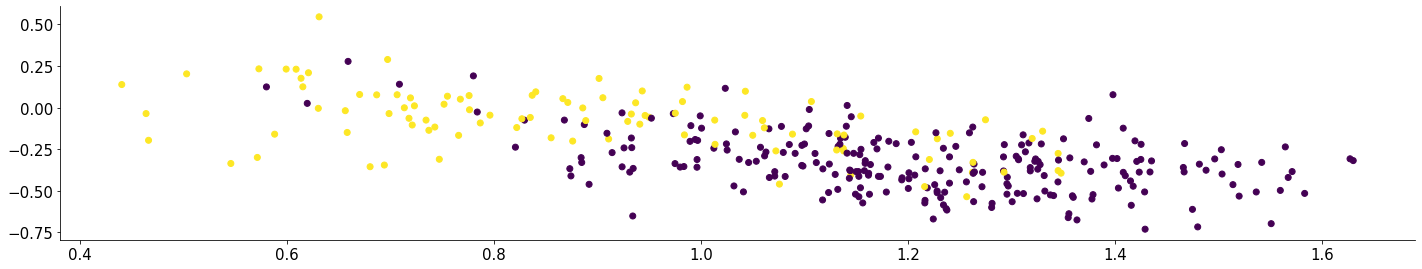

In [ ]:
from sklearn.cluster import KMeans
X_1, X_2 = pc_10ms[0][:, 50:130].mean(axis=1), pc_10ms[1][:, 50:130].mean(axis=1)
plt.scatter(X_1, X_2, c=slow_resp)

In [ ]:
X=pc_10ms[:,:,50:130].mean(axis=2).T
X.shape

(340, 5)

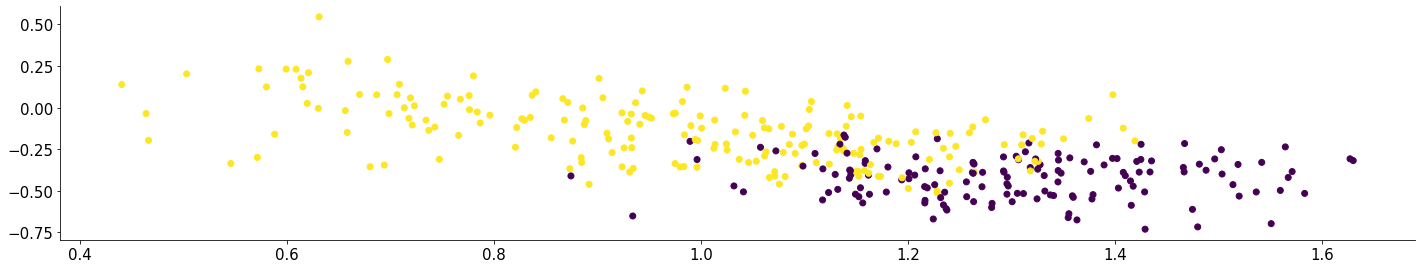

In [ ]:
km = KMeans(n_clusters=2).fit(X)
pred_labels = km.labels_
plt.scatter(X_1, X_2, c=pred_labels)

In [ ]:
(pred_labels==slow_resp).mean()

0.6441176470588236

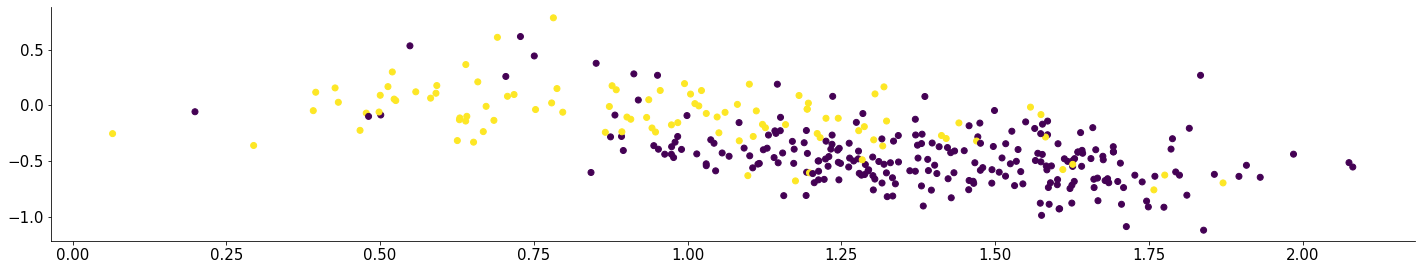

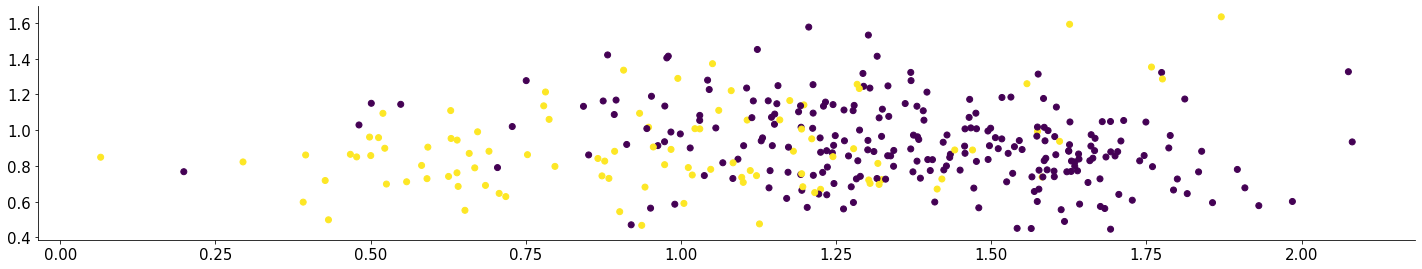

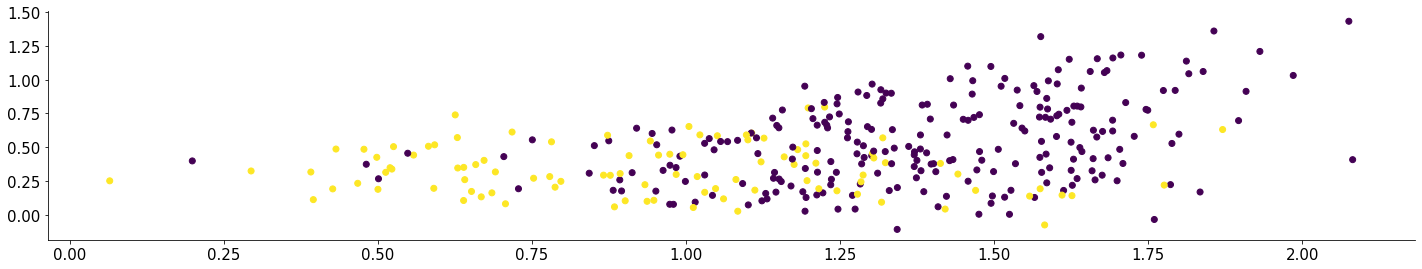

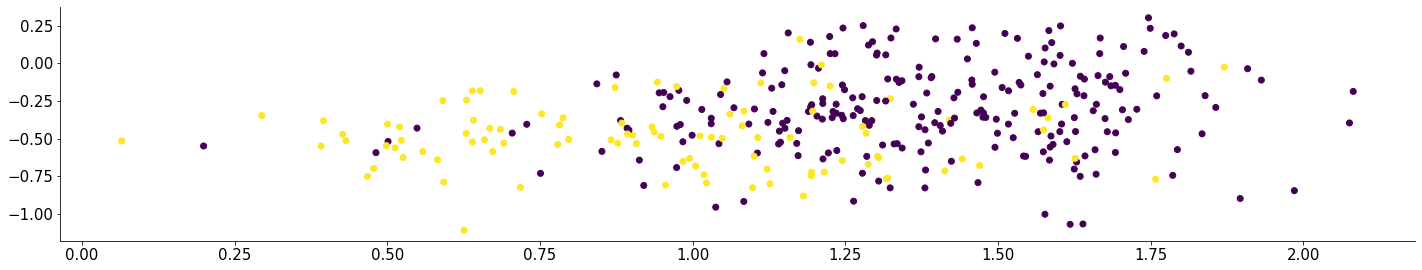

In [ ]:
from sklearn.cluster import KMeans
for i in range(4):
    fig = plt.figure()
    X_1, X_2 = pc_10ms[0][:, 75:100].mean(axis=1), pc_10ms[i+1][:, 75:100].mean(axis=1)
    plt.scatter(X_1, X_2, c=slow_resp)

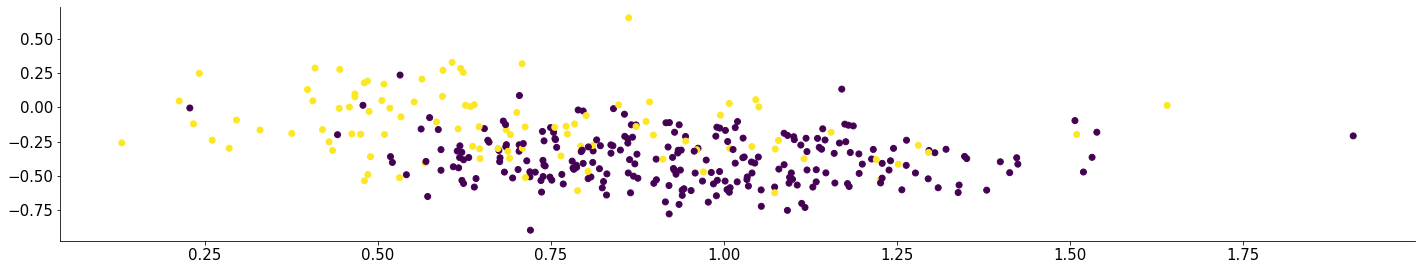

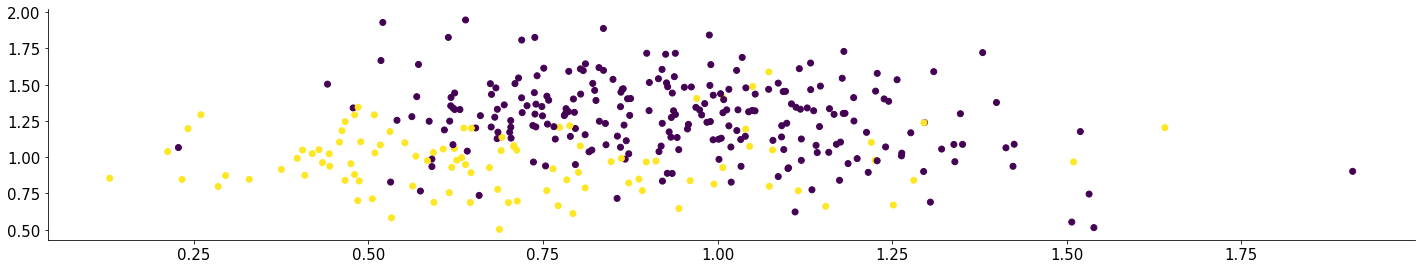

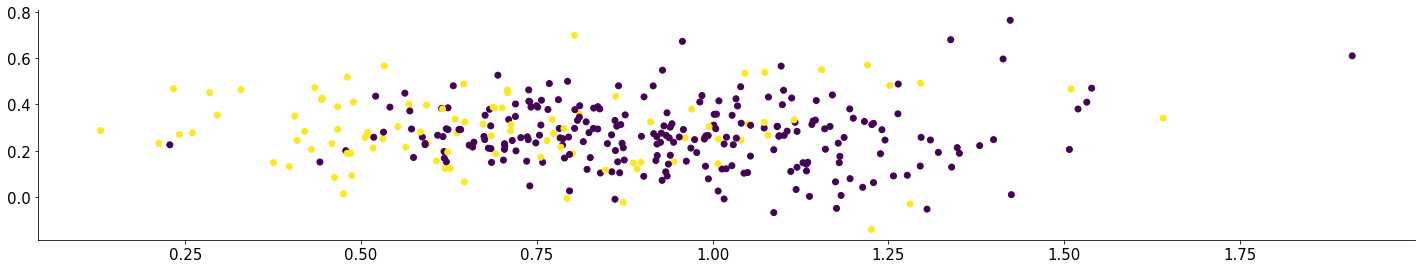

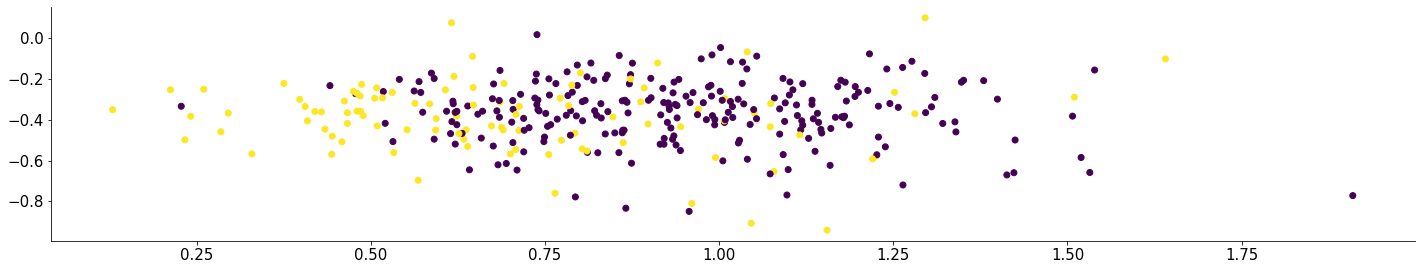

In [ ]:
from sklearn.cluster import KMeans
for i in range(4):
    fig = plt.figure()
    X_1, X_2 = pc_10ms[0][:, 125:150].mean(axis=1), pc_10ms[i+1][:, 125:150].mean(axis=1)
    plt.scatter(X_1, X_2, c=slow_resp)

goodness of clustering at different time periods

Text(0.5, 1.0, 'Cluster center distance vs. Time bins')

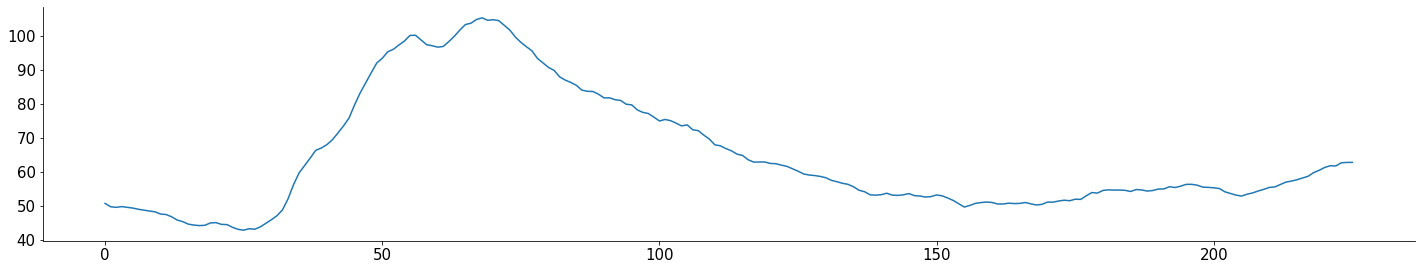

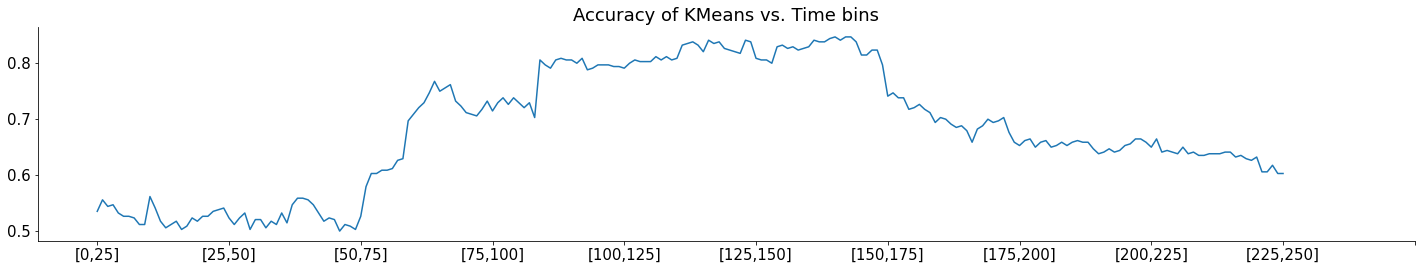

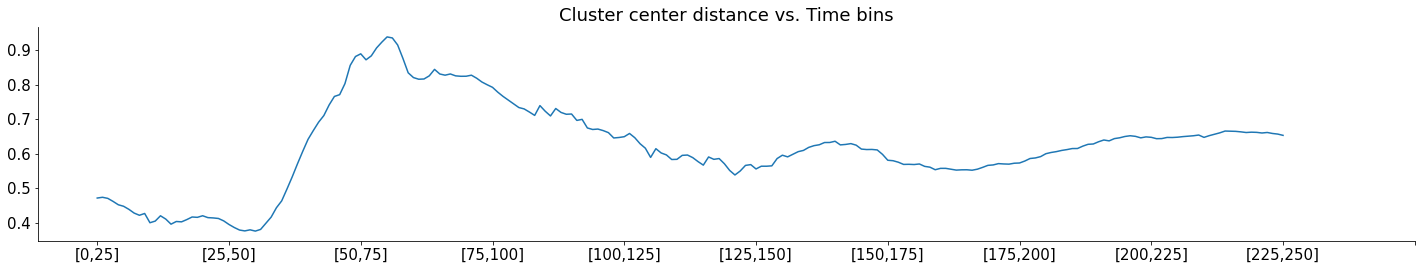

In [ ]:
clust_center_diff = []
distortions = []
acc = []
x = [f'[{x},{x+25}]' for x in range(0,250-24,25)]
for i in range(0,250-24):
    X = pc_10ms[:, :, i:i+25].mean(axis=2).T
    km = KMeans(n_clusters=2).fit(X)
    distortions.append(km.inertia_)
    acc.append(max(np.mean(km.labels_==slow_resp), 1 - np.mean(km.labels_==slow_resp)))
    clust_center_diff.append(np.linalg.norm(km.cluster_centers_[1]-km.cluster_centers_[0]))
fig=plt.figure();plt.plot(distortions)
fig=plt.figure();plt.plot(acc); plt.xticks(np.linspace(0,250,11),labels=x); plt.title("Accuracy of KMeans vs. Time bins")
fig=plt.figure();plt.plot(clust_center_diff); plt.xticks(np.linspace(0,250,11),labels=x); plt.title("Cluster center distance vs. Time bins")

0.8088235294117647


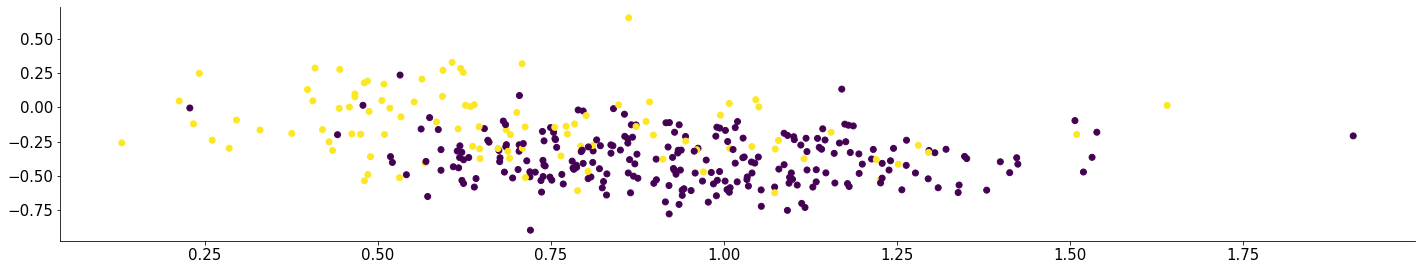

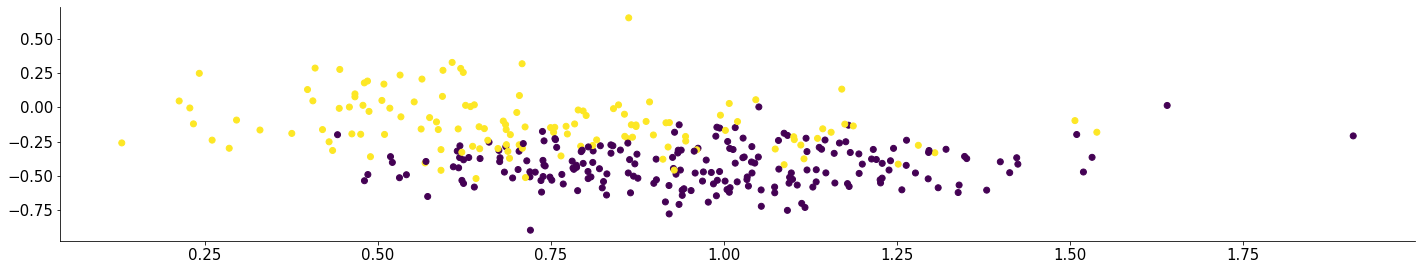

In [ ]:
from sklearn.metrics import completeness_score
X = pc_10ms[:, :, 125:150].mean(axis=2).T
km = KMeans(n_clusters=2).fit(X)
print(np.mean(slow_resp==km.labels_))
plt.scatter(X[:,0], X[:,1], c=slow_resp)
fig=plt.figure();plt.scatter(X[:,0], X[:,1], c=km.labels_)


In [ ]:
# accuracy of clustering

0.8088235294117647

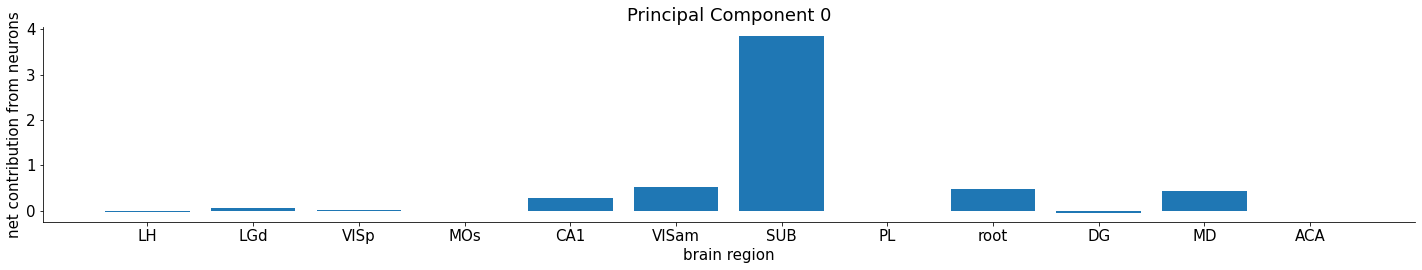

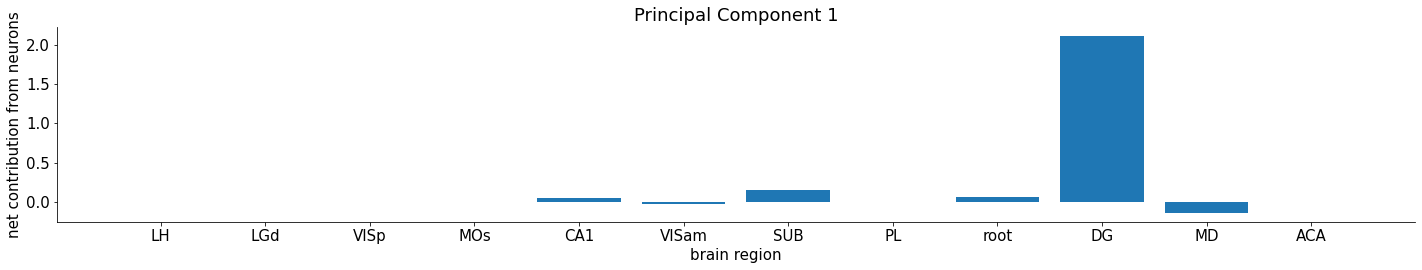

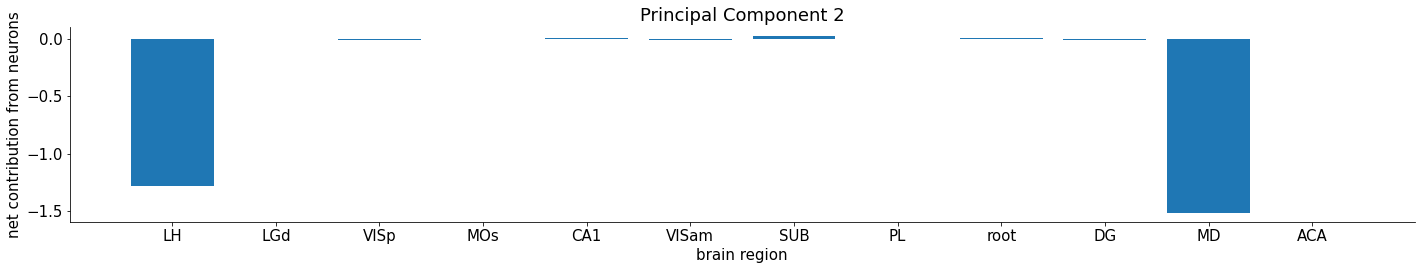

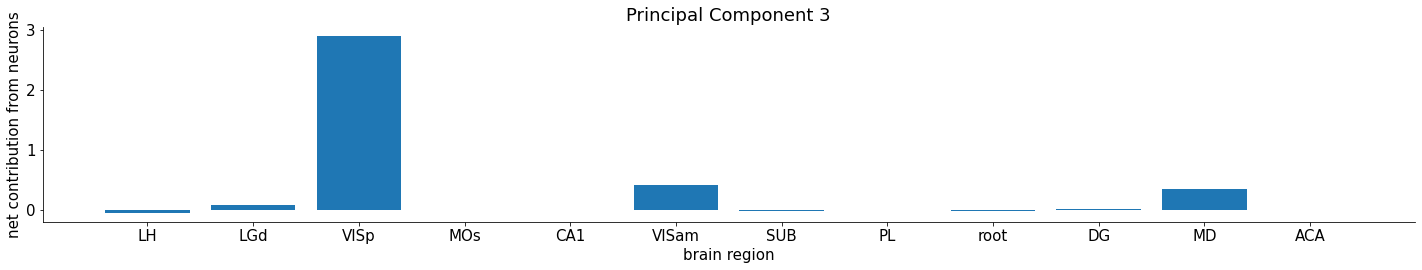

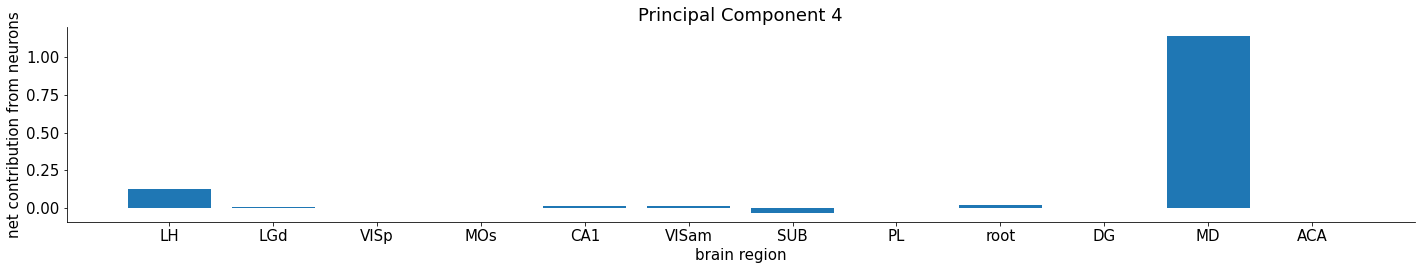

In [19]:
from sklearn.decomposition import PCA, SparsePCA
import pandas as pd
droll = np.reshape(dat['spks'][:,:,51:130], (NN,-1)) # first 80 bins = 1.6 sec
droll = droll - np.mean(droll, axis=1)[:, np.newaxis]
model = SparsePCA(n_components = 5).fit(droll.T)
W = model.components_
pc_10ms = W @ np.reshape(dat['spks'], (NN,-1))
pc_10ms = np.reshape(pc_10ms, (5, -1, NT))
W = pd.DataFrame(W).T
W['brain_area'] = dat['brain_area']

W.sort_values(by = ['brain_area'])
areas = set(W['brain_area'].to_list())
#average principal component values by each brain region to see how they contribute
#but also need to factor out zeros
W_nozeros = W.iloc[W.index[W.sum(axis = 1) != 0]]
avg_area_pcs = {}
for area in areas:
    if area in list(W_nozeros['brain_area']):
        avg_area_pcs[area] = W_nozeros.iloc[np.where(W_nozeros['brain_area'] == area)].sum(axis = 0)[:5]
    else:
        avg_area_pcs[area] = pd.Series([0.0] * 5)
avg_area_pcs = pd.DataFrame(avg_area_pcs, dtype = float)
for row in range(5):
    plt.figure()
    plt.title("Principal Component " + str(row))
    plt.bar(avg_area_pcs.columns,avg_area_pcs.iloc[row])
    plt.xlabel('brain region')
    plt.ylabel('net contribution from neurons')

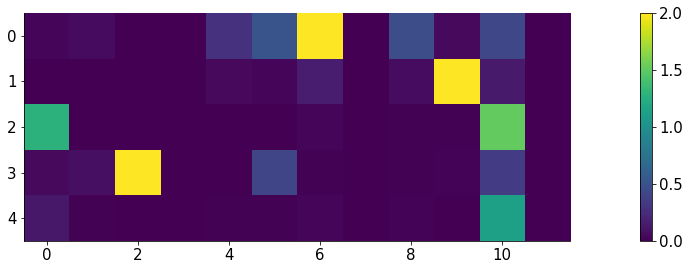

In [23]:
plt.imshow(abs(avg_area_pcs), vmin=0, vmax=2); plt.colorbar()

In [ ]:
# next step: do clustering across sessions